# Solving the Botnet Defense MFG/MFC Problem Using the HJB and Kolmogorov Equations
## By: Farez Siddiqui


This mini-project is an extension of my [previous project](https://github.com/fmsiddi/AFL-RL-Botnet-MFG/blob/master/botnet_MFG.ipynb) where Andrea Angiuli, Jean-Pierre Fouque, and Mathieu Lauriere's [new reinforcement learning algorithm](https://arxiv.org/abs/2006.13912) was used to solve Vassili Kolokoltsov and Alain Benoussan's proposed [Botnet Defense MFG problem](https://arxiv.org/abs/1511.06642), using René Carmona and François Delarue's setup of the problem as demonstrated in their textbook [Probabilistic Theory of Mean Field Games with Applications](https://link.springer.com/book/10.1007/978-3-319-58920-6).

Whereas in the last project Angiuli et al.'s RL algorithm was used to solve the problem by approximating the solution using Q-Learning, this time around I wanted to learn more about how one solves the problem analytically using the Hamiltonian-Jacobi-Bellman equation to solve for the optimal control, and the Kolmogorov Forward equation to solve for the stationary distribution.



### Nash Equilibrium

In essence, a Mean Field Game (MFG) is an optimization problem whereby there are $N$ players in an environment, all of whom are trying to minimize their respective cost functions $J^{1},J^{2},...,J^{N}$ (where each $J^{i}$ represents player $i$'s cost function). Each player takes an action $\alpha^{i}$, and each player's cost function uses every other player's action as input in determining the cost for that player (player $i$'s cost function is $J^{i}(\alpha^{1},\alpha^{2},...,\alpha^{N})$).

Trying to simultaneously optimize every single player's cost function ($N$ functions in total) can be overly complicated and expensive in terms of computational resources (especially when the number of players $N$ is large). Taking a page out of the [particle physicists' book](https://en.wikipedia.org/wiki/Mean-field_theory), mathematicians instead opt to treat the problem asymptotically by taking $N \rightarrow \infty$, the logic being that instead of trying to solve $N$ cost functions, by taking $N \rightarrow \infty$ you can observe the asymptotic behavior of the system by treating all the players as a mean field (characterized by a probability distribution $\mu$ which serves as a proxy for the distribution of the states of other players), thereby simplifying the problem. If the  states the players can finds themselves in have $n$ dimensions (meaning a point $X = (x^{1},...,x^{n}) \in E^{n}$), then the probability measure is:
<br><br><center>$\overline{\mu}^{n}_{X}=\frac{1}{n}\sum^{n}_{i=1}\delta_{x^i}$</center><br>
There is a large amount of rigorous math in the first chapter of Carmona and Delarue's book that establishes the necessary foundation in order to properly treat taking the limit $N \rightarrow \infty$. This involves proving that the sequence of probability measures $\mu^{(k)}$ as $k \rightarrow \infty$ converges to some probability distribution $\mu$, and many, _many_ other proofs that make this entire construction mathematically robust and well-posed. I will not be covering this material in this notebook.

Instead, I will briefly summarize that the result of this is that the minimum cost function becomes $\underset{\alpha \in A}{\inf}J(\alpha,\mu)$ for a fixed probability distribution $\mu$ meant to represent the other players in aggregate, and the action $\alpha$ meant to represent the action of any generic player. However, $\mu$ will change as a result of all the players' actions, meaning although that set of actions may have minimized the cost function for _that_ particular $\mu$, the environment has changed and there is a new optimal control to find.

The problem is considered finished when after finding the optimal control for all players, the distribution $\mu$ "does not change". What we are looking for is a _stationary distribution_ $\hat{\mu}$ whereby $\underset{\alpha \in A}{\inf}J(\alpha,\mu)$ is found and the following equality is satisfied:
<br><br><center>$\int_A J(\alpha,\hat{\mu})\space\hat{\mu}(d\alpha) = \underset{\mu\in\mathcal{P(A)}}{\inf}\int_A J(\alpha,\hat{\mu})\space\mu(d\alpha)$</center><br>
The point $(\alpha,\hat{\mu})$ is considered a __Nash Equilibrium__ if the 2 conditions listed above are satisfied. In order to satisfy the first condition of finding $\underset{\alpha \in A}{\inf}J(\alpha,\mu)$, (finding the optimal control $\alpha$ that minimizes the cost function $J(\alpha,\mu)$ for a given $\mu$), we need a method that allows us to use the state dynamics and in determining the cost function, and then a means to select the optimal action at every point in time.

#### Describing the State Space Dynamics With the Q-matrix

When describing the state space dynamics with a discrete and finite number of states, we can establish a rate matrix known as the _infinitesimal generator of continuous time Markovian dynamics on a finite state space E_: $L^{\mu,\alpha}_{t}$, otherwise known as a __Q matrix__ (taken from Section 7.2 of Carmona and Delarue's MFG [book](https://link.springer.com/book/10.1007/978-3-319-58920-6)):

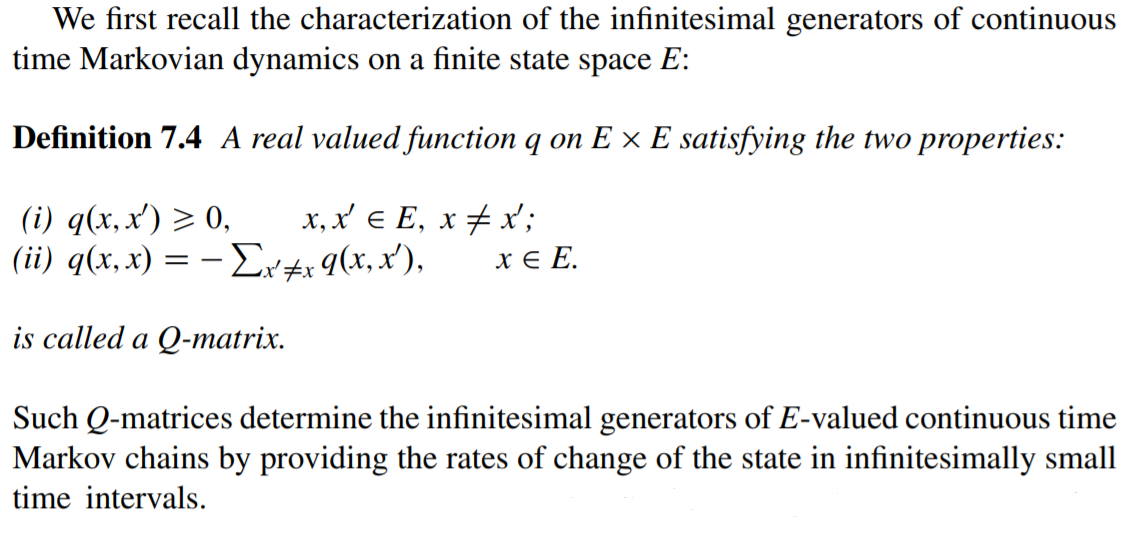

With a transition rate matrix in hand, we have the means to describe the state dynamics of the environment. What needs to be done now is to tie the state dynamics together with the cost function into an optimization scheme so that the optimal control $\underset{\alpha}{\arg\inf}\space J(\alpha,\mu)$. I will cover a little bit of classical control theory in continuous time first to explain how this will be done.

### The Dynamic Programming Principle

In optimal control theory in continuous time, the goal is to find the optimal control $\alpha(t)$ that minimizes 
<br><br><center>$u(x,t) = \int_{t}^{T}J(x(s),\alpha(s))\space ds+g(x(T))$</center><br>
where $J(x(t),\alpha(t))$ is the running cost function that takes the one-dimesional state $x$ at time $t$ and the action $\alpha$ at time $t$, integrated over the finite (in this case) time horizon $[0,T]$ to give the total running cost over time. $g(x(T))$ is the terminal cost function at time $T$ (no action is taken in the final state so $g$ only takes the final state as input).

The evolution of the state $x(t)$ can be described as an ODE: 
<br><br><center>$\frac{dx}{dt} = f(x(s),\alpha(s)),\quad x(\textit{initial time t})=x_t$</center><br>
The challenge is to find $\alpha(t)$ that is optimal $\forall t\in[0,T]$. One numerical scheme is known as the Dynamic Programming Principle (DPP) whereby you solve the problem backwards in time. In essence, you start with some increment of time $\Delta t$ and observe the problem starting at initial time $t = T - \Delta t$. You then approximate the incremented state dynamics as: 
<br><br><center>$x(s+\Delta t) = x(s) + f(x(s),\alpha(s))\Delta t$</center><br> 
For this "initial" time interval $[T-\Delta t,T]$ the control function $\alpha(t)$ is no longer a function of time (since it is piecewise constant for a single time-step) but rather a single action or vector of actions $\alpha$. So now we can approximate the integral $u(x,t)$ for this time interval as:
<br><br><center>$u(x,T-\Delta t) = J(x,\alpha)\Delta t + g(x + f(x,\alpha)\Delta t)$</center><br> 
whereby the optimal control can be found by picking $\alpha$ that minimizes the above sum for each state $x$. In other words, we are to evaluate:
<br><br><center>$u^{*}(x,T-\Delta t) = \underset{\alpha}{\min}\{J(x,\alpha)\Delta t + g(x + f(x,\alpha)\Delta t)\}$</center><br>
for each state $x$. By doing so, we have found the optimal control $\alpha$ for the time interval $[T-\Delta t,T]$. This scheme continues with repeating the above process for the time interval $[T-2\Delta t,T-\Delta t]$, however in this case (and for the remaining time intervals we replace the terminal cost function $g$ with the $u^*$ we found in the previous step:
<br><br><center>$u^{*}(x,T-2\Delta t) = \underset{\alpha}{\min}\{J(x,\alpha)\Delta t + u(x + f(x,\alpha)\Delta t,\space T-\Delta t)\}$</center><br>
thereby finding the optimal control for _that_ time interval, and repeating until the optimal control for the time interval $[t,t+\Delta t]$ is found. At the end of it, you will have the optimal control for every state for every time interval, and have a sufficient approximation of the solution. In order to get the exact solution, the limit $\Delta t \rightarrow 0$ needs to be taken, which will lead us to the Hamiltonian-Jacobi-Bellman equation.

### Using the HJB Equation to Find the Optimal Control

Let's recall the optimal value function from above for some $t<s<t+\Delta t<T$ where $\alpha(s)$ is assumed to be constant for $t<s<t+\Delta t$:
<br><br><center>$u^{ * }(x,t)\le J(x,\alpha)\Delta t + u(x + f(x,\alpha)\Delta t,\space t+\Delta t)\$</center>

with equality if the optimal action $\alpha$ is taken:
<br><br><center>$u^{ * }(x,t)=\underset{\alpha}{\min}\{J(x,\alpha)\Delta t + u(x + f(x,\alpha)\Delta t,\space t+\Delta t)\}$</center><br>
Letting $\alpha^*$ be the control solves the equation above, I will rewrite it as:
<br><br><center>$u^{ * }(x,t)=J(x,\alpha^{ * })\Delta t + u(x + f(x,\alpha^{ * })\Delta t,\space t+\Delta t)$</center><br>
Doing a first-order Taylor expansion of $u^*$ on the right hand side yields:
<br><br><center>$u^{ * }(x,t)=J(x,\alpha^{ * })\Delta t + u^{ * }(x,t) + (\nabla u\cdot f(x,\alpha^{ * })\Delta t+\frac{\partial u}{\partial t}\Delta t) + \text{error terms}$</center><br>
$u^*(x,t)$ can now be subtracted from both sides, yielding:
<br><br><center>$0=J(x,\alpha^{ * })\Delta t + \nabla u\cdot f(x,\alpha^{ * })\Delta t+\frac{\partial u}{\partial t}\Delta t + \text{error terms}$</center><br>
Dividing both sides by $\Delta t$ allows us to remove the term from the equation entirely:
<br><br><center>$0=J(x,\alpha^{ * }) + \nabla u\cdot f(x,\alpha^{ * })+\frac{\partial u}{\partial t} + \text{error terms}$</center><br>
Finally, after taking the limit $\Delta t\rightarrow 0$, rearranging the terms on the right hand side, and rewriting with the original $\min$ function we are left with:
<br><br><center>$0=\frac{\partial u}{\partial t} + \underset{\alpha}{\min}\{J(x,\alpha) + \nabla u\cdot f(x,\alpha)\}$</center><br>
This PDE equation coupled with the terminal condition $u(x,T) = g(x(T))$ is known as the **Hamiltonian-Jacobi-Bellman (HJB) equation**.

Additionally, the part of the equation dependent on the control $\alpha$:
<br><br><center>$H(\nabla u,x) = \underset{\alpha}{\min}\{J(x,\alpha) + \nabla u\cdot f(x,\alpha)\}$</center><br>
is known as the **Hamiltonian**. This Hamiltonian function is what we will compute in our numerical scheme in order to solve for the optimal control.

In the case of the problem being solved later, the state space is discrete, so instead of using $f(x,\alpha)$, the **Q matrix** defined above will be used. However, it should be noted there are different Q matrices for each $\alpha$ that may be taken. In order to use the Q matrix in the Hamiltonian such that the optimal control is considered, we must take the row from the Q matrix of the associated optimal action for that specific state when solving.

To start with notation, the way we would write the state transition rate for a state $x$ going to state $x^{'}$ at time $t$ after taking action $\alpha$ would be:
<br><br><center>$q_t(x,x^{'}) = \lambda_t(x,x^{'},\mu_t,\alpha)$</center><br>
using the optimal action $\alpha^*$:
<br><br><center>$q^*_t(x,x^{'}) = \lambda_t(x,x^{'},\mu_t,\alpha^*)$</center><br>

So for example, if we wish to compute the Hamiltonian of a specific state $x$ at some point in time $t$:
<br><br><center>$H(t,x,\mu,u) = \underset{{x^{'}\in E}}{\sum}\lambda_t(x,x^{'},\mu,\alpha^*)\space u(x^{'})+J(x,\alpha^{ * })$</center><br>

### Using the Kolmogorov Forward Equation to Find the Stationary Distribution

Finding the optimal control for a given distribution is only the first step in finding the Nash equilibria. The next step involves finding the stationary distribution. First, we must establish that there is a time-evolution of probability distributions $\mu_t$ as time moves forward. As actions are taken, players will find themselves in different states, and thus the distribution will change. Since we already have a Q matrix that defines for us the rate at which the states can change, we can use this to calculate the rate of change of $\mu_t$ for a given state $x$:
<br><br><center>$\frac{\partial \mu_t(\{x\})}{\partial t}=\underset{{x^{'}\in E,x^{'}\ne x}}{\sum}\mu_t(\{x^{'}\})q^{ * }_t(x^{'},x)-\underset{{x^{'}\in E,x^{'}\ne x}}{\sum}\mu_t(\{x\})q^{ * }_t(x,x^{'})$</center><br>
This is known as the **Kolmogorov Forward equation**. In essence, is says that the change in the empirical distribution of a state $x$ can be calculated by observing the inflows from all the other potential states $x^{'}$ to the state $x$:
<br><br><center>$\underset{{x^{'}\in E,x^{'}\ne x}}{\sum}\mu_t(\{x^{'}\})q^{ * }_t(x^{'},x)$</center><br>
and subtracting the outflow from the state $x$ to all the other potential states $x^{'}$:
<br><br><center>$\underset{{x^{'}\in E,x^{'}\ne x}}{\sum}\mu_t(\{x\})q^{ * }_t(x,x^{'})$</center><br>

After an optimal control is found for a given distribution $\mu$, we then use that control to determine the Q matrix used in the Kolmogorov Forward equation to compute the flow of $\mu_t$ over time. This process is repeated until $\frac{\partial \mu_t(\{x\})}{\partial t}$ is sufficiently small, at which point we have arrrived at a stationary distribution for the optimal control, thereby finding the Nash equilibria for the problem.

### The Botnet Defense Problem

The Botnet problem (as set up by Carmona and Delarue) is a great first problem to get one's toes wet since it has finitely many states (which are discrete) as well as finitely many actions (that are also discrete). This greatly simplifies much of the theory that would otherwise be necessary for problems with infinitely many states, or a continuous state space and control dynamics (as is the case when the problem is described in terms of stochastic differential equations). It was first proposed by Vassili Kolokoltsov and Alain Bensoussan in their 2015 paper: __[Mean-field-game model for Botnet defense in Cyber-security](https://arxiv.org/abs/1511.06642)__

The paper models the interaction between a network of computers and a malicious attacker who is trying to infect them as an MFG problem. The vast number of computers that are in a network makes it amenable to being treated as a mean field, and the random propagation of infection, the various states the computers can be in, and decisions that the computers can make given their state and the costs being incurred also make it suitable for stochastic optimal control theory. Its "simplicity" comes from the fact that the state space and action space are both discrete and finite. 

In this problem, a network of computers is considered where each computer can be in one of four states at any given time:
<br>**Defended and Infected (DI)
<br>Defended and Susceptible (DS)
<br>Unprotected and Infected (UI)
<br>Unprotected and Susceptible (US)**

The cost incurred for being defended $k_D$ and the cost of being infected is $k_I$ (both for one unit of time)

The network of computers is under constant threat of infection by a malicious attacker (their constant threat is in fact quantified in this problem by the parameter $v_H$ as the rate of "direct effort", a quantification of how hard the attacker is trying). A computer in the network's susceptibility to direct infection by the attacker is quantified by the rate $q_{inf}^{D}$ if the computer is Defended, and $q_{inf}^{U}$ if the computer is Unprotected. These rates together make up a computer's rate of infection as a result of direct attack (depending on its state):

**$v_{H}q_{inf}^{D}$: The rate of infection by direct attack if the computer is Defended
<br>$v_{H}q_{inf}^{U}$: The rate of infection by direct attack if the computer is Unprotected**

Once a computer is infected, it can infect other computers at 2 of 4 rates depending on its own state and the state of the computers it is infecting:

**$\beta_{UU}$: The rate of infection from Unprotected computers to other Unprotected computers
<br>$\beta_{UD}$: The rate of infection from Unprotected computers to Defended computers
<br>$\beta_{DU}$: The rate of infection from Defended computers to Unprotected computers
<br>$\beta_{DD}$: The rate of infection from Defended computers to other Defended computers**

While the computer is infected, it will recover at rate $q_{rec}^{D}$ if it is Defended or $q_{rec}^{U}$ if is Unprotected.

Every computer has a binary decision to make at every point in time: _"Do I switch my defense level?"_

This action can be represented by a 1 if the computer is actively trying to change from Unprotected to Defended or Defended to Unprotected, and 0 if the computer is opting to stay either Unprotected or Defended. The speed at which the computer is able to change its defense level is given by the rate $\lambda$.

Finally we use $\mu(x)$ as the empirical distribution of states of the computers (i.e. $\mu(DI) = 0.25$ means 25% of computers in the network are Defended and Infected)

With all these parameters established, the instantaneous transition rate matrix (the Q matrix) for the state of a computer is given by the following if the action is 0 (the computer is opting stay at its current defense level):

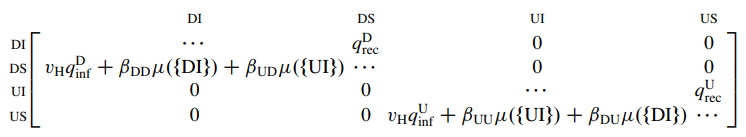

And the following if the action is 1 (the computer is actively trying to change its defense level):

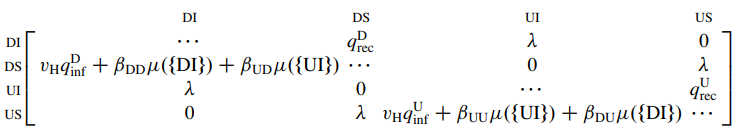

Where the "$...$" in each row represents the negative of the sum of the entries of that row.

(Matrices taken from Carmona and Delarue's [book](https://link.springer.com/book/10.1007/978-3-319-58920-6))

In order to convert this instantaneous rate matrix to a transition probability matrix, its corresponding matrix exponential must be found by multiplying it by the time-step length identified by the numerical procedure and then using something like the Padé method to find the matrix exponential.

René Carmona and François Delarue solve this problem analytically in Chapter 7 Section 2.3 of the first volume of their 2 volume textbook __[Probabilistic Theory of Mean Field Games with Applications](https://link.springer.com/book/10.1007/978-3-319-58920-6)__ using the HJB and Kolmogorov equations stated previously (the values they used for the parameters described above can be found at the top of the code section below). I will be attempting to recreate the distribution flow graphs using the same initial distributions they used below:

1) $\mu_{0}(DI) = \mu_{0}(DS) = \mu_{0}(UI) = \mu_{0}(US) = 0.25$

2) $\mu_{0}(DI) = 1$, $\mu_{0}(DS) = \mu_{0}(UI) = \mu_{0}(US) = 0$

3) $\mu_{0}(DI) = \mu_{0}(DS) = \mu_{0}(UI) = 0$, $\mu_{0}(US) = 1$

Each analytical solution to the state distribution flow provided by Carmona and Delarue will be shown after presenting the output of the code for comparison.

### Note on Code

The following code was written solely by me, however I used the code of a graduate student, [Jimin Li](https://www.linkedin.com/in/jm-lin/), at the University of California - Santa Barbara as a reference in constructing my solution. He and a team of other PhD students did so as a section of a larger project in the past. Their impressive presentation on this problem can be found in the github repository [here](https://github.com/alexbstl/meanfield-cybersecurity)

The below cell establishes the parameters to use for the Botnet problem (as outlined by Carmona and Delarue) as well as the Q matrix that defines the instantaneous rate of change from one state to another depending on the action taken:

In [3]:
import numpy as np
from numpy import random as rnd
from scipy.linalg import expm
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd

# spread of infection rates between computers
beta_UU = .3
beta_UD = .4
beta_DU = .3
beta_DD = .4

# recovery and infection rates
q_rec_D = .5
q_rec_U = .4
q_inf_D = .4
q_inf_U = .3

# cost rates
k_D = .3
k_I = .5

# rate of direct effort by herder
v_H = .6

# speed of response rate for taking action to change state
lambd = .8

# states:
# index 0: DI
# index 1: DS
# index 2: UI
# index 3: US

# cost array (each element corresponds with each state's incurred cost for 1 unit of time)
f = np.array([k_D + k_I, k_D, k_I, 0])


def Q_matrix(action, mu):
    '''
    Transition rate matrix for a given action and state distribution
    As described in the Botnet defense problem by Kolokoltsov & Bensoussan
    '''
    Q_matrix = np.empty((4,4))
    
    if action == 0:
        Q_matrix[0] = np.array([-q_rec_D, q_rec_D, 0, 0])
        Q_matrix[1] = np.array([v_H*q_inf_D + beta_DD*mu[0] + beta_UD*mu[2], -v_H*q_inf_D - beta_DD*mu[0] - beta_UD*mu[2], 0, 0])
        Q_matrix[2] = np.array([0, 0, -q_rec_U, q_rec_U])
        Q_matrix[3] = np.array([0, 0, v_H*q_inf_U + beta_UU*mu[2] + beta_DU*mu[0], -v_H*q_inf_U - beta_UU*mu[2] - beta_DU*mu[0]])
    elif action == 1:
        Q_matrix[0] = np.array([-q_rec_D - lambd, q_rec_D, lambd, 0])
        Q_matrix[1] = np.array([v_H*q_inf_D + beta_DD*mu[0] + beta_UD*mu[2], -v_H*q_inf_D - beta_DD*mu[0] - beta_UD*mu[2] - lambd, 0, lambd])
        Q_matrix[2] = np.array([lambd, 0, -q_rec_U - lambd, q_rec_U])
        Q_matrix[3] = np.array([0, lambd, v_H*q_inf_U + beta_UU*mu[2] + beta_DU*mu[0], -v_H*q_inf_U - beta_UU*mu[2] - beta_DU*mu[0] - lambd])
    
    return Q_matrix

# used later to populate initialized array of distributions
def rnd_prob_array(n):
    
    p = rnd.rand(n)
    p = p/p.sum()
    
    return p

The cells below are the actual solving of the problem using the HJB equation and subsequent updating of the distribution flow for different initial distributions. It should be noted that for problems in general, the process of finding the optimal control then calculating the distribution flow are done repeatedly over a number of iterations until the Nash equilibrium is found. However for this problem, a solution is reached in only 1 iteration, as made evident by the subsequent plots. Since the stationary distribution for each case could be identified visually, there was no need to use the Kolmogorov Forward equation. Though in general, a tolerance should be set for the computed $\frac{\partial \mu_t}{\partial t}$ such that if it is less than the set tolerance, the optimization may terminate.

Computing distribution flow for iteration 1: 100%|███████████████████████████████| 1000/1000 [00:00<00:00, 1433.21it/s]


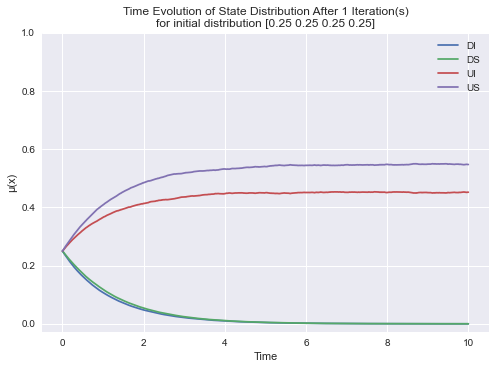

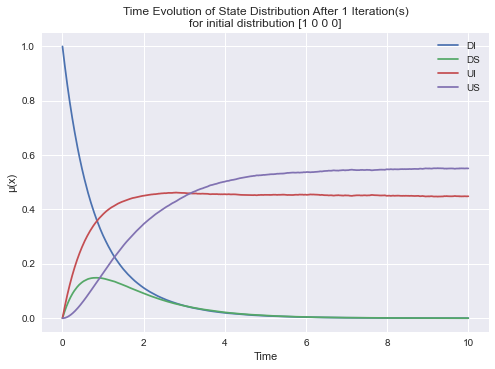

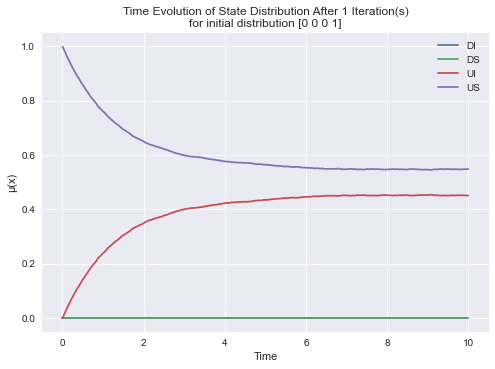

In [6]:
# define length of time interval as well as number of time-steps
T = 10
n = 1000
dt = T/n

# the 3 initial distributions
mu_0 = [np.array([.25,.25,.25,.25]),np.array([1,0,0,0]),np.array([0,0,0,1])]

# number of iterations to run
iterations = 1

for j in range(len(mu_0)):

    # initialize value, distribution, and action arrays
    u = np.zeros((n+1, 4))
    u[-1] = f
    mu = np.array([rnd_prob_array(4) for i in range(n+1)])
    phi = np.zeros((n+1, 4))

    for i in range(iterations):
        # solve for optimal control phi for given distribution mu using DPP and HJB equation
        for t in tqdm(reversed(range(1, n+1)), desc="Solving for optimal control for iteration {}".format(i+1), total=n):
            
            # create two Q matrices, one for each action
            Q_matrices = [Q_matrix(a, mu[t-1]) for a in [0, 1]]
            # calculate transition probabilities for both matrices
            P_matrices = [expm(Q * dt) for Q in Q_matrices]
            # compute Hamiltonian for each matrix
            H = np.array([np.matmul(P, u[t].T) + f*dt for P in P_matrices])
            # pick action for each state that minimizes Hamiltonian
            phi[t-1] = np.argmin(H, axis=0)
            u[t-1] = H.min(axis=0)

        # initialize distribution array that will be used in Kolmogorov equation
        mu_new = np.zeros((n+1, 4))
        mu_new[0] = mu_0[j]

        # compute new distribution for a given optimal action
        for t in tqdm(range(n), desc="Computing distribution flow for iteration {}".format(i+1)):

            # compute probability array for each state using its respective optimal action at that time
            P_matrices = [expm(Q_matrix(phi[t][state], mu[t]) * dt) for state in range(4)]
            P = [P_matrices[state][state] for state in range(4)]
            # compute new distribution
            mu_new[t+1] = np.matmul(mu_new[t], P)

        mu = mu_new
    
    df_mu = pd.DataFrame(mu, columns=['DI','DS','UI','US'], index=np.linspace(0, T, n+1))
    plt.figure(j)
    plt.plot(df_mu)
    plt.title('Time Evolution of State Distribution After {} Iteration(s)\nfor initial distribution {}'.format(iterations,mu_0[j]))
    plt.xlabel('Time')
    plt.ylabel('μ(x)')
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.legend(['DI','DS','UI','US'])

Comparing these plots to the plots produced by Carmona and Delarue in their book, it shows that the optimization scheme was successfully implemented (NOTE: please refer to the legend in both plots to compare rather than the line colors):

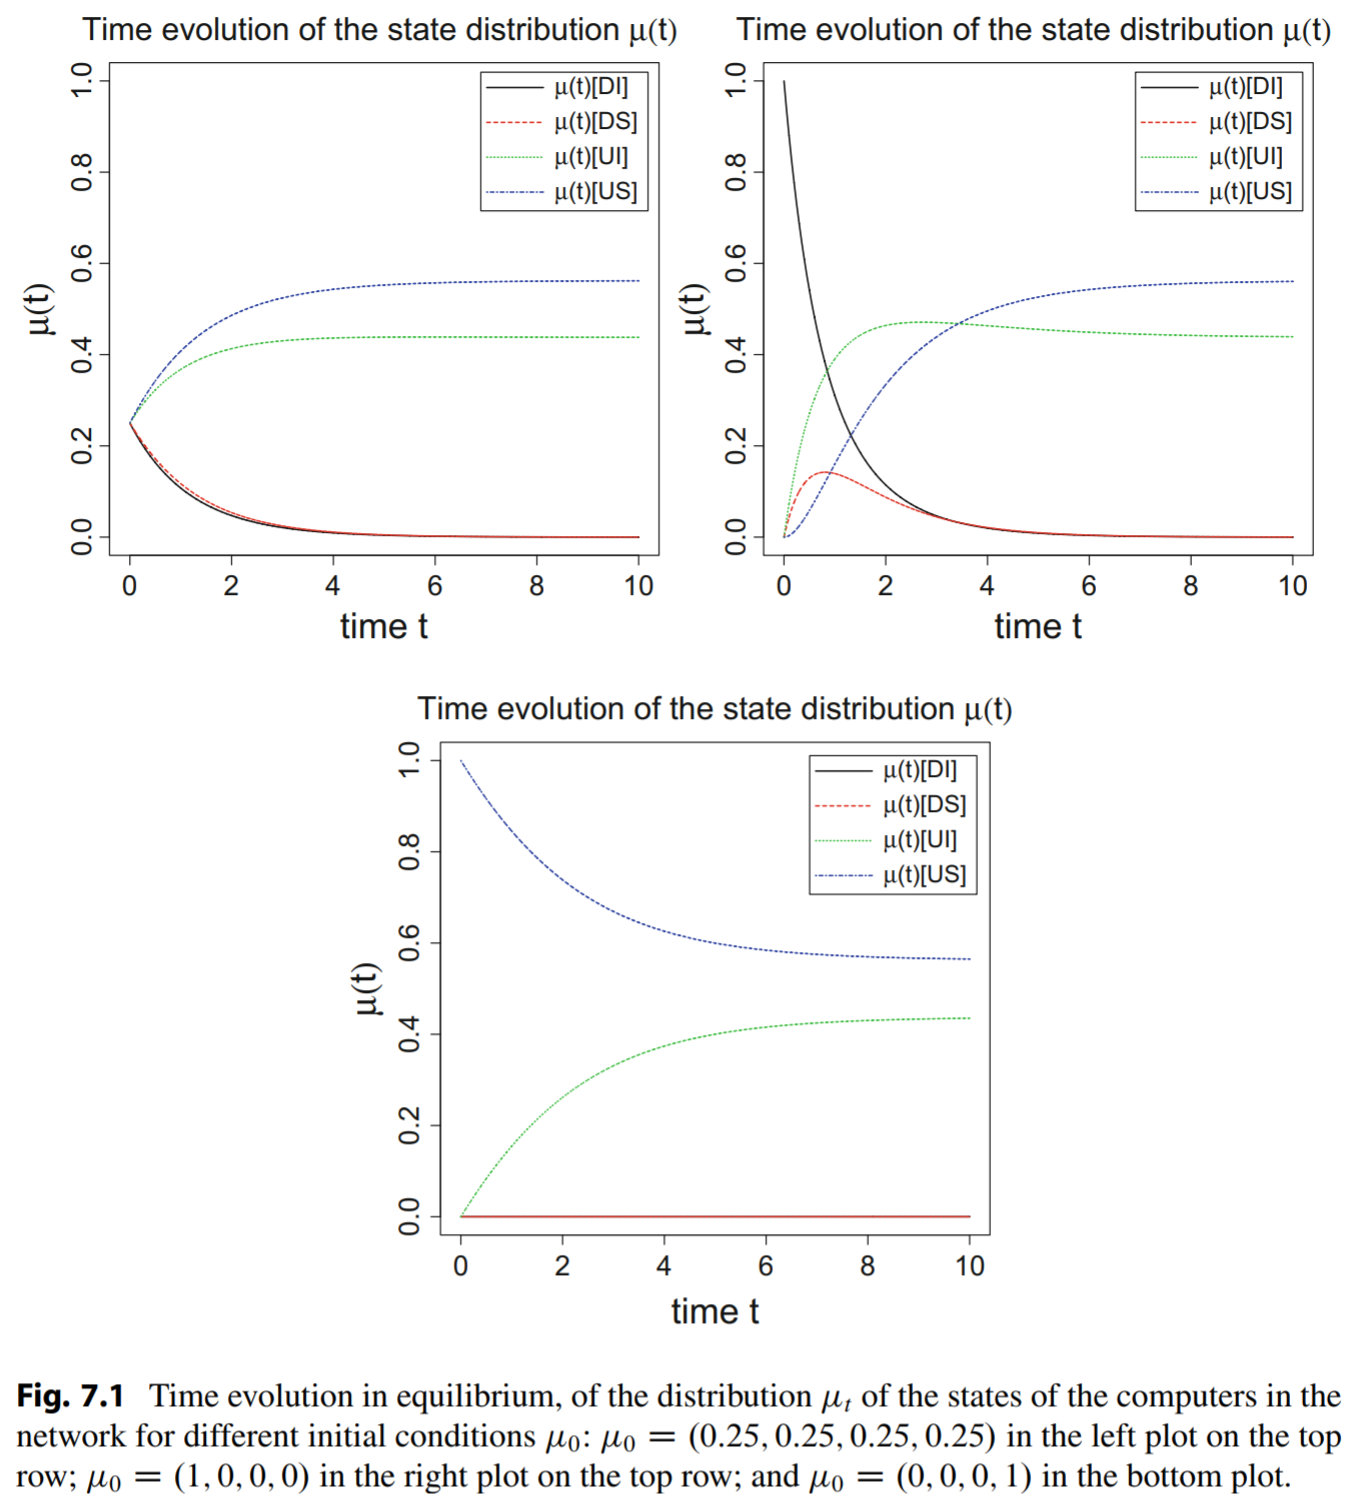

# References

1) [Mean-field-game model for Botnet defense in Cyber-security](https://arxiv.org/abs/1511.06642) - Vassili Kolokoltsov and Alain Bensoussan (2015)

2) [Probabilistic Theory of Mean Field Games with Applications](https://link.springer.com/book/10.1007/978-3-319-58920-6) - René Carmona and François Delarue (2018)

3) [A Brief Introduction to Optimal Control](https://www.math.nyu.edu/~kohn/calculus-of-variations/2009/hamilton-jacobi.pdf) - Robert V. Kohn (2009)

4) [Jimin Li, Cosmin Borsa, and Alex Bernstein's code](https://github.com/alexbstl/meanfield-cybersecurity)